**Entendendo a demanda**

Quando uma pessoa cliente realiza uma compra e recebe o produto, ela tem a oportunidade de deixar uma avaliação.

Nesse processo, atribui uma nota ao item e redige um comentário detalhando sua experiência, que pode ser positiva ou negativa, mencionando aspectos que lhe agradaram ou desapontaram. O e-commerce recebe centenas de avaliações mensalmente.

**Desafios**

Um dos desafios que enfrentamos é a ausência de um método automático para identificar se a experiência da pessoa cliente foi positiva ou negativa. Isso revela a necessidade de um sistema capaz de classificar as avaliações de forma automática. Ao receber cada avaliação, o sistema poderá categorizar o sentimento como positivo ou negativo.

In [43]:
import pandas as pd

df = pd.read_csv('dataset_avaliacoes.csv')
df.head()

,ID_avaliacao,avaliacao,nota,sentimento
0,81841,"Esse smartphone superou minhas expectativas, r...",5,positivo
1,28031,o cheiro e muito desagradavel!! pra quem se in...,2,negativo
2,91332,"Eu fiz a compra a loja não entregou o produto,...",1,negativo
3,110045,"Atendeu minhas expectativas, só achei a luz ru...",4,positivo
4,36929,"Gostei muito, só achei que ficou a desejar a q...",5,positivo


In [44]:
df.shape

(15501, 4)

Não há dados nulos

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15501 entries, 0 to 15500
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ID_avaliacao  15501 non-null  int64 
 1   avaliacao     15501 non-null  object
 2   nota          15501 non-null  int64 
 3   sentimento    15501 non-null  object
dtypes: int64(2), object(2)
memory usage: 484.5+ KB


Quantidade de sentimentos positivos e negativos

In [46]:
df.value_counts('sentimento')

sentimento
positivo    7890
negativo    7611
Name: count, dtype: int64

### Transformando textos em dados numéricos (Bag of Words (BOW) -> Bolsa de palavras)

Ainda não é possível classificar os sentimentos, pois para que o algorítmo entenda, antes é necessário processar esses dados para que se tornem numéricos.

A ferramenta *CountVetorizer* irá contar a frequência de cada palavra no texto.

A grande vantagem da técnica BOW é sua simplicidade. Ela transforma textos em números facilitando a análise e processamento por algoritmos de aprendizado de máquina. Porém, como esta técnica não considera a ordem das palavras, ele pode ignorar aspectos importantes do contexto e do significado do texto.

Mais adiante, no projeto, iremos explorar técnicas mais avançadas que superam essa limitação.

In [47]:
from sklearn.feature_extraction.text import CountVectorizer

# Exemplo de uso:
textos = ['Comprei um produto ótimo', 'Comprei um produto ruim']

vetorizar = CountVectorizer()
bag_of_words = vetorizar.fit_transform(textos)
bag_of_words

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 8 stored elements and shape (2, 5)>

In [48]:
matriz_esparsa = pd.DataFrame.sparse.from_spmatrix(bag_of_words, columns=vetorizar.get_feature_names_out())
matriz_esparsa

,comprei,produto,ruim,um,ótimo
0,1,1,0,1,1
1,1,1,1,1,0


Em seguida, iremos implementar esta tecnica nos nossos dados

Iremos configurar o parametro *lowercase* para false para não converter todas as palavras em minúsculas.

Assim como, teremos que configurar a variável *max_features* para que a quantidade de colunas não fique muito grande, pois grandes quantidades de colunas não é o ideal do ponto de vista computacional, pois requer muito processamento e recursos.

In [49]:
vetorizar = CountVectorizer(lowercase=False, max_features=50)
bag_of_words = vetorizar.fit_transform(df['avaliacao'])
bag_of_words.shape

(15501, 50)

In [50]:
matriz_esparsa = pd.DataFrame.sparse.from_spmatrix(
    bag_of_words,
    columns=vetorizar.get_feature_names_out())
matriz_esparsa

,Não,Produto,ainda,antes,as,até,bem,bom,chegou,com,...,qualidade,que,recebi,recomendo,se,sem,tem,um,uma,veio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,1,2,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15496,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
15497,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
15498,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
15499,0,1,0,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


### Treinando o modelo

In [51]:
from sklearn.model_selection import train_test_split

SEED = 42

X_train, X_test, y_train, y_test = train_test_split(bag_of_words, df['sentimento'], random_state=SEED)

In [52]:
from sklearn.linear_model import LogisticRegression

regressao_logistica = LogisticRegression()

regressao_logistica.fit(X_train, y_train)

acuracia = regressao_logistica.score(X_test, y_test)
print(f'Acurácia: {acuracia*100:.2f}%')

Acurácia: 80.08%


### Quais as palavras mais utilizadas nas avaliações?

Como podemos visualizar as palavras mais utilizadas nas avaliações?

In [53]:
from wordcloud import WordCloud

todas_palavras = [texto for texto in df['avaliacao']]
#todas_palavras

O gráfico abaixo entregará uma nuvem de palavras independente do sentimento.

(np.float64(-0.5), np.float64(799.5), np.float64(499.5), np.float64(-0.5))

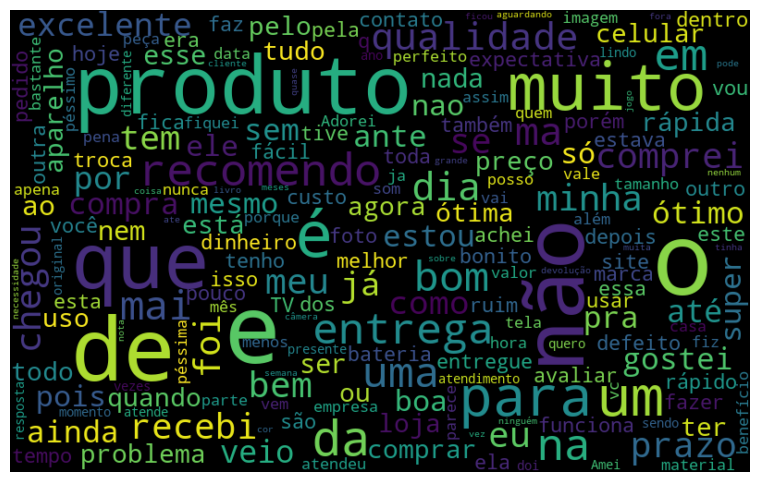

In [54]:
import matplotlib.pyplot as plt

# Primeiramente iremos unir todas as frases em uma só string
todas_palavras = ' '.join([texto for texto in df['avaliacao']])

# Collocations como 'False' faz o wordcloud considerar apenas palavras únicas e não uma junção de palavras (frase)
nuvem_palavras = WordCloud(width=800, height=500, max_font_size=110, collocations=False).generate(todas_palavras)

plt.figure(figsize=(12,6))
plt.imshow(nuvem_palavras, interpolation='bilinear')
plt.axis('off')

Abaixo iremos criar uma função para poder gerar uma nuvem de palavras com filtro por sentimento, onde será possível visualizar todas as palavras que são definidas como negativas e positivas.

In [55]:
def nuvem_palavras(texto, coluna_texto, sentimento):
    # Pega todas as linhas com o sentimento específico e retorna todos os valores da coluna especificada
    texto_sentimento = texto.query(f'sentimento == "{sentimento}"')[coluna_texto]
    
    texto_unido = ' '.join(texto_sentimento)
    
    print(f'Sentimento: {sentimento}')
    nuvem_palavras = WordCloud(width=800, height=500, max_font_size=110, collocations=False).generate(texto_unido)
    plt.figure(figsize=(12,6))
    plt.imshow(nuvem_palavras, interpolation='bilinear')
    plt.axis('off')
    plt.show()

Todas as palavras com sentimento **negativo**.

Sentimento: negativo


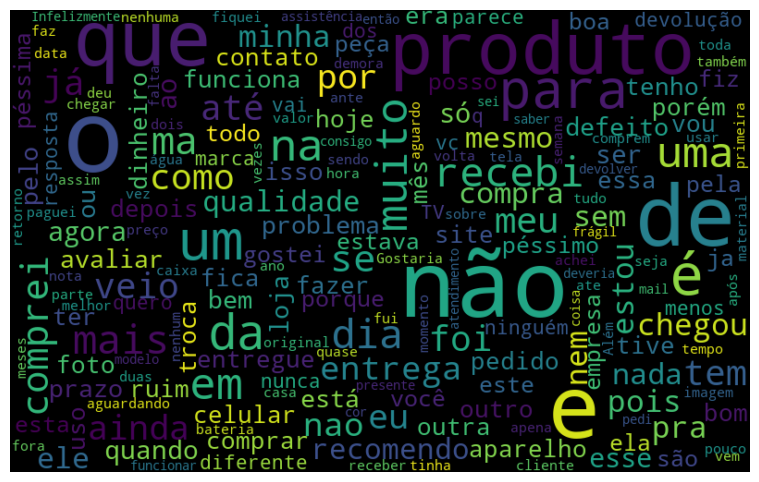

In [56]:
nuvem_palavras(df, 'avaliacao', 'negativo')

Todas as palavras com sentimento **positivo**.

Sentimento: positivo


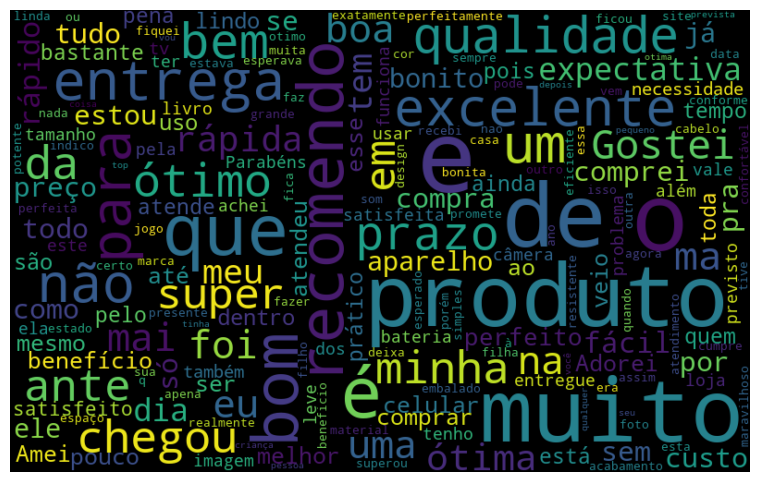

In [57]:
nuvem_palavras(df, 'avaliacao', 'positivo')

### Qual a frequência das palavras?

Antes de verificar a frequência das palavras no texto precisamos separa-las.

Iremos separar o texto em unidades menores chamados de *tokens* com a técnica de **Tokenização** com a biblioteca *nltk*.

A **tokenização** é o processo de dividir o texto em *tokens*, que são unidades menores, como palavras ou subpalavras. Seria como um *frase.split(' ')* no C# ou Javascript. 

**Exemplo:**
- ['Este','produto','é','excelente']

A *tokenização* é um dos primeiros passos para manipular textos.

In [58]:
#import nltk
#nltk.download('all')

from nltk import tokenize, FreqDist

# A técnica de tokenização para este caso será de espaços em branco
tokenizer = tokenize.WhitespaceTokenizer()
token_frases = tokenizer.tokenize(todas_palavras) # Aqui iremos utilizar todas as frases do nosso dataset concatenadas em apenas uma string
#token_frases

**Frequência de cada palavra**

In [59]:
frequencia = FreqDist(token_frases)

freq_df = pd.DataFrame({
    'palavra': list(frequencia.keys()),
    'frequencia': list(frequencia.values())
})

# Exibe as 10 palavras mais frequentes
freq_df.sort_values('frequencia', ascending=False).head(10)

,palavra,frequencia
8,e,11813
6,o,10865
29,de,10280
19,a,8873
46,que,7657
22,não,7286
163,é,4786
63,produto,4765
177,com,4641
130,do,4583


Visualização das 10 palavras mais utilizadas

[Text(0, 0.5, 'Contagem'), Text(0.5, 0, 'Palavra')]

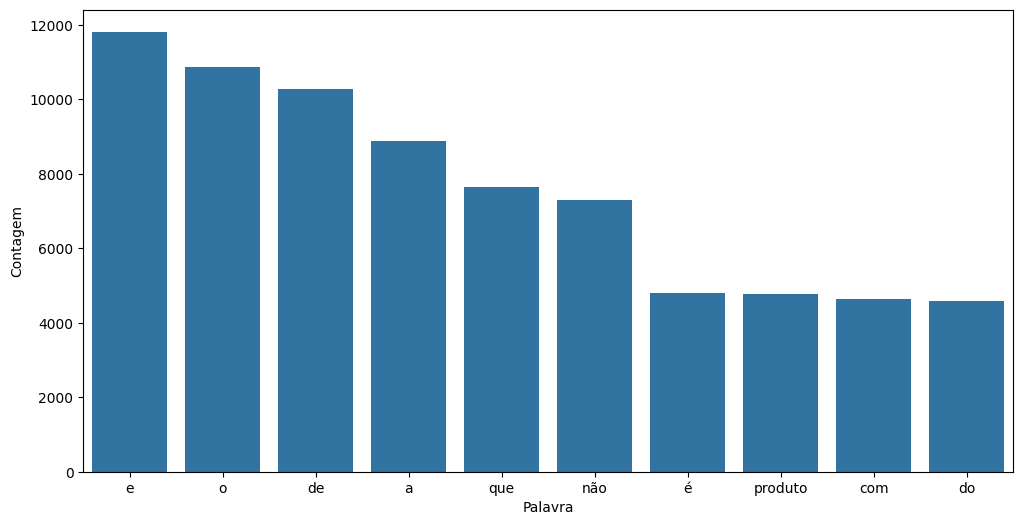

In [60]:
import seaborn as sns

plt.figure(figsize=(12,6))
ax = sns.barplot(freq_df.sort_values('frequencia', ascending=False).head(10), x='palavra', y='frequencia')
ax.set(ylabel='Contagem', xlabel='Palavra')

### Tratamento de dados (Removendo Stopwords)

*Stopwords* seriam as preposições, artigos, conjunções, etc, que tem um baixo valor semântico, ou seja, essas palavras não agregam muita informação para o nosso objetivo de análise de sentimentos. Seria interessante fazer um tratamento de dados para removermos essas palavras que não tem muita relevância para o nosso caso.

Manter essas palavras pode fazer com que o modelo tenha ruídos e não tenha tanta eficácia.

Utilizaremos a biblioteca *nltk* para realizar este tratamento de dados textuais.

In [61]:
from nltk.corpus import stopwords

# stopword.words('portuguese') adquire um array de todas as 'stopwords' da lingua portuguesa
palavras_irrelevantes = stopwords.words('portuguese')
#palavras_irrelevantes

A seguir, iremos criar uma nova coluna no nosso dataframe sem as *stopwords*.

In [62]:
frases_processadas = []

for frase in df['avaliacao']:
    palavras_tokenizadas = tokenizer.tokenize(frase)

    # Filtra apenas palavras que não estejam na lista de 'palavras_irrelevantes'
    frase_tratada = [palavra for palavra in palavras_tokenizadas if palavra not in palavras_irrelevantes]

    frases_processadas.append(' '.join(frase_tratada))

df['frase_tratada'] = frases_processadas

df.head()

,ID_avaliacao,avaliacao,nota,sentimento,frase_tratada
0,81841,"Esse smartphone superou minhas expectativas, r...",5,positivo,"Esse smartphone superou expectativas, recomendo"
1,28031,o cheiro e muito desagradavel!! pra quem se in...,2,negativo,cheiro desagradavel!! pra incomoda nao recomen...
2,91332,"Eu fiz a compra a loja não entregou o produto,...",1,negativo,"Eu fiz compra loja entregou produto, compra fe..."
3,110045,"Atendeu minhas expectativas, só achei a luz ru...",4,positivo,"Atendeu expectativas, achei luz ruim, nada dif..."
4,36929,"Gostei muito, só achei que ficou a desejar a q...",5,positivo,"Gostei muito, achei ficou desejar qualidade fo..."


Funções para automatizar a classificação e visualização de frequência dos textos

In [63]:
# Treina e testa um modelo
def classificar_texto(data, coluna_texto, coluna_classificacao):
    vetorizar = CountVectorizer(lowercase=False, max_features=50)
    bag_of_words = vetorizar.fit_transform(data[coluna_texto])

    SEED = 42
    X_train, X_test, y_train, y_test = train_test_split(bag_of_words, data[coluna_classificacao], random_state=SEED)

    regressao_logistica = LogisticRegression()
    regressao_logistica.fit(X_train, y_train)

    acuracia = regressao_logistica.score(X_test, y_test)
    print(f'Acurácia do modelo com a coluna "{coluna_texto}": {acuracia*100:.2f}%')

# Gera um gráfico de barras sobre a frequência das palavras
def grafico_frequencia(data, coluna_texto, quantidade):
    todas_palavras = ' '.join([texto for texto in data[coluna_texto]])
    tokenizador = tokenize.WhitespaceTokenizer()
    frequencia = FreqDist(tokenizador.tokenize(todas_palavras))

    df_frequencia = pd.DataFrame({
        "palavra": list(frequencia.keys()),
        "frequencia": list(frequencia.values())
    })

    df_frequencia.sort_values('frequencia', ascending=False, inplace=True)

    plt.figure(figsize=(12,6))
    ax = sns.barplot(df_frequencia.head(quantidade), x='palavra', y='frequencia')
    ax.set(ylabel='Contagem', xlabel='Palavra')
    plt.xticks(rotation=45)
    

Porém, ainda temos alguns problemas:
- Temos ainda alguns artigos maiúsculos
- Palavras iguais porém com a inicial maiúscula e outra minúscula, por exemplo, a palavra produto.
- Caracteres especiais (vírgula)

Acurácia do modelo com a coluna "frase_tratada": 81.76%


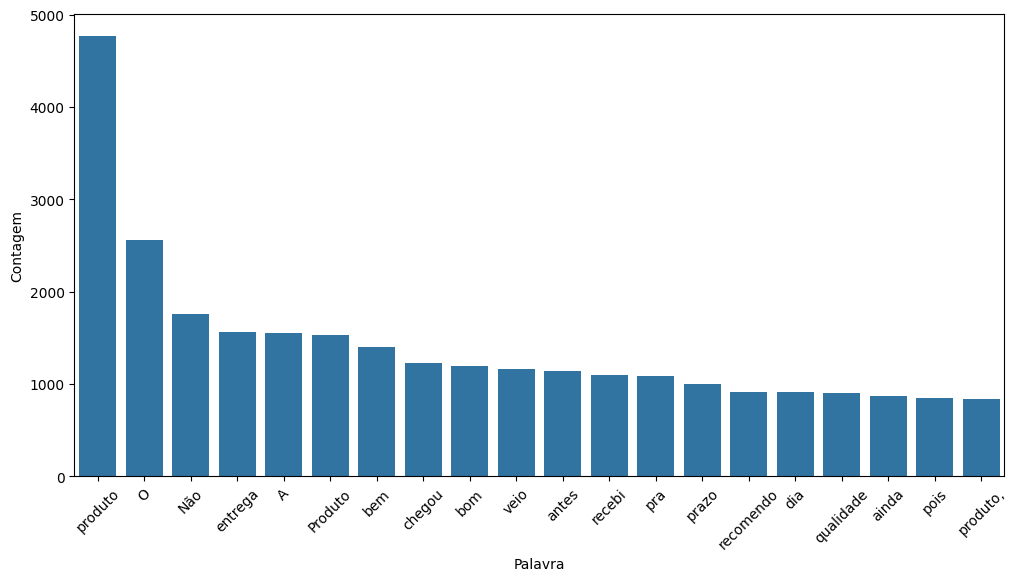

In [64]:
classificar_texto(df, 'frase_tratada', 'sentimento')
grafico_frequencia(df, 'frase_tratada', 20)

**Removendo pontuações**

Novamente iremos realizar a tokenização para separar as palavras dos caracteres especiais, no caso, das pontuações.

Para isto, iremos utilizar a classe de tokenização *WordPunctTokenizer*.

Adicionamos uma nova verificação: o método *isalpha()* que vai verificar se a palavra faz parte do alfabeto, ou seja, que não seja um caracter especial.

In [65]:
from nltk.tokenize import WordPunctTokenizer

token_pontuacao = WordPunctTokenizer()
frases_processadas = []

for frase in df['frase_tratada']:
    palavras_tokenizadas = token_pontuacao.tokenize(frase)

    # Remove as pontuações do texto com o método isalpha()
    frase_tratada = [palavra for palavra in palavras_tokenizadas if palavra.isalpha() and palavra not in palavras_irrelevantes]

    frases_processadas.append(' '.join(frase_tratada))

df['frase_tratada_2'] = frases_processadas

df.head()

,ID_avaliacao,avaliacao,nota,sentimento,frase_tratada,frase_tratada_2
0,81841,"Esse smartphone superou minhas expectativas, r...",5,positivo,"Esse smartphone superou expectativas, recomendo",Esse smartphone superou expectativas recomendo
1,28031,o cheiro e muito desagradavel!! pra quem se in...,2,negativo,cheiro desagradavel!! pra incomoda nao recomen...,cheiro desagradavel pra incomoda nao recomendoo
2,91332,"Eu fiz a compra a loja não entregou o produto,...",1,negativo,"Eu fiz compra loja entregou produto, compra fe...",Eu fiz compra loja entregou produto compra fei...
3,110045,"Atendeu minhas expectativas, só achei a luz ru...",4,positivo,"Atendeu expectativas, achei luz ruim, nada dif...",Atendeu expectativas achei luz ruim nada dific...
4,36929,"Gostei muito, só achei que ficou a desejar a q...",5,positivo,"Gostei muito, achei ficou desejar qualidade fo...",Gostei achei ficou desejar qualidade fotos Ach...


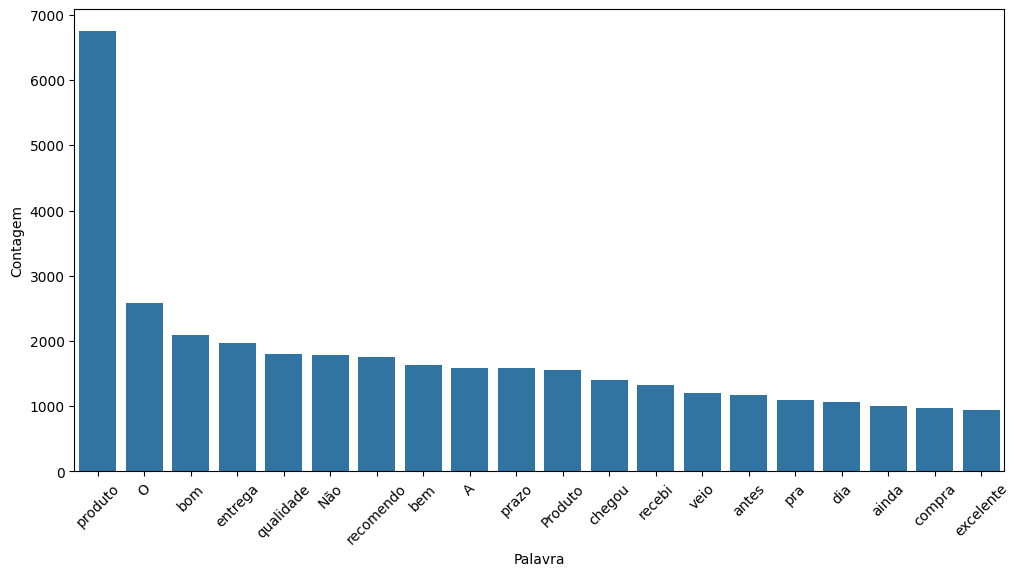

In [66]:
grafico_frequencia(df, 'frase_tratada_2', 20)

**Removendo acentuações**

Para remover as acentuações iremos utilizar a biblioteca *unidecode*.

In [67]:
from unidecode import unidecode

# Remove acentos da coluna 'frase_tratada_2'
sem_acentos = [unidecode(texto) for texto in df['frase_tratada_2']]

# Remove acentos do array de palavras_irrelevantes
stopwords_sem_acentos = [unidecode(texto) for texto in palavras_irrelevantes]

In [68]:
df['frase_tratada_3'] = sem_acentos
frases_processadas = []

for frase in df['frase_tratada_3']:
    palavras_tokenizadas = token_pontuacao.tokenize(frase)

    # Realiza o filtro por palavras que não sejam stopwords após a remoção dos acentos
    frase_tratada = [palavra for palavra in palavras_tokenizadas if palavra.isalpha() and palavra not in stopwords_sem_acentos]

    frases_processadas.append(' '.join(frase_tratada))

df['frase_tratada_3'] = frases_processadas

df.head()

,ID_avaliacao,avaliacao,nota,sentimento,frase_tratada,frase_tratada_2,frase_tratada_3
0,81841,"Esse smartphone superou minhas expectativas, r...",5,positivo,"Esse smartphone superou expectativas, recomendo",Esse smartphone superou expectativas recomendo,Esse smartphone superou expectativas recomendo
1,28031,o cheiro e muito desagradavel!! pra quem se in...,2,negativo,cheiro desagradavel!! pra incomoda nao recomen...,cheiro desagradavel pra incomoda nao recomendoo,cheiro desagradavel pra incomoda recomendoo
2,91332,"Eu fiz a compra a loja não entregou o produto,...",1,negativo,"Eu fiz compra loja entregou produto, compra fe...",Eu fiz compra loja entregou produto compra fei...,Eu fiz compra loja entregou produto compra fei...
3,110045,"Atendeu minhas expectativas, só achei a luz ru...",4,positivo,"Atendeu expectativas, achei luz ruim, nada dif...",Atendeu expectativas achei luz ruim nada dific...,Atendeu expectativas achei luz ruim nada dific...
4,36929,"Gostei muito, só achei que ficou a desejar a q...",5,positivo,"Gostei muito, achei ficou desejar qualidade fo...",Gostei achei ficou desejar qualidade fotos Ach...,Gostei achei ficou desejar qualidade fotos Ach...


**Uniformizando o texto para caracteres minúsculos**

Ainda restaram alguns problemas de normalização, no caso, algumas palavras estão em minúsculas e outras em maiúsculas, devemos então normalizar nossas frases do dataset.

Basicamente, iremos deixar todas as frases do nosso dataset com letras minúsculas.

In [69]:
frases_processadas = []

for frase in df['frase_tratada_3']:
    # Realiza a normalização do texto para letras minúsculas
    frase = frase.lower()

    palavras_tokenizadas = token_pontuacao.tokenize(frase)
    frase_tratada = [palavra for palavra in palavras_tokenizadas if palavra.isalpha() and palavra not in stopwords_sem_acentos]

    frases_processadas.append(' '.join(frase_tratada))

df['frase_tratada_4'] = frases_processadas

df.head()

,ID_avaliacao,avaliacao,nota,sentimento,frase_tratada,frase_tratada_2,frase_tratada_3,frase_tratada_4
0,81841,"Esse smartphone superou minhas expectativas, r...",5,positivo,"Esse smartphone superou expectativas, recomendo",Esse smartphone superou expectativas recomendo,Esse smartphone superou expectativas recomendo,smartphone superou expectativas recomendo
1,28031,o cheiro e muito desagradavel!! pra quem se in...,2,negativo,cheiro desagradavel!! pra incomoda nao recomen...,cheiro desagradavel pra incomoda nao recomendoo,cheiro desagradavel pra incomoda recomendoo,cheiro desagradavel pra incomoda recomendoo
2,91332,"Eu fiz a compra a loja não entregou o produto,...",1,negativo,"Eu fiz compra loja entregou produto, compra fe...",Eu fiz compra loja entregou produto compra fei...,Eu fiz compra loja entregou produto compra fei...,fiz compra loja entregou produto compra feita ...
3,110045,"Atendeu minhas expectativas, só achei a luz ru...",4,positivo,"Atendeu expectativas, achei luz ruim, nada dif...",Atendeu expectativas achei luz ruim nada dific...,Atendeu expectativas achei luz ruim nada dific...,atendeu expectativas achei luz ruim nada dific...
4,36929,"Gostei muito, só achei que ficou a desejar a q...",5,positivo,"Gostei muito, achei ficou desejar qualidade fo...",Gostei achei ficou desejar qualidade fotos Ach...,Gostei achei ficou desejar qualidade fotos Ach...,gostei achei ficou desejar qualidade fotos ach...


Acurácia do modelo com a coluna "frase_tratada_4": 83.05%


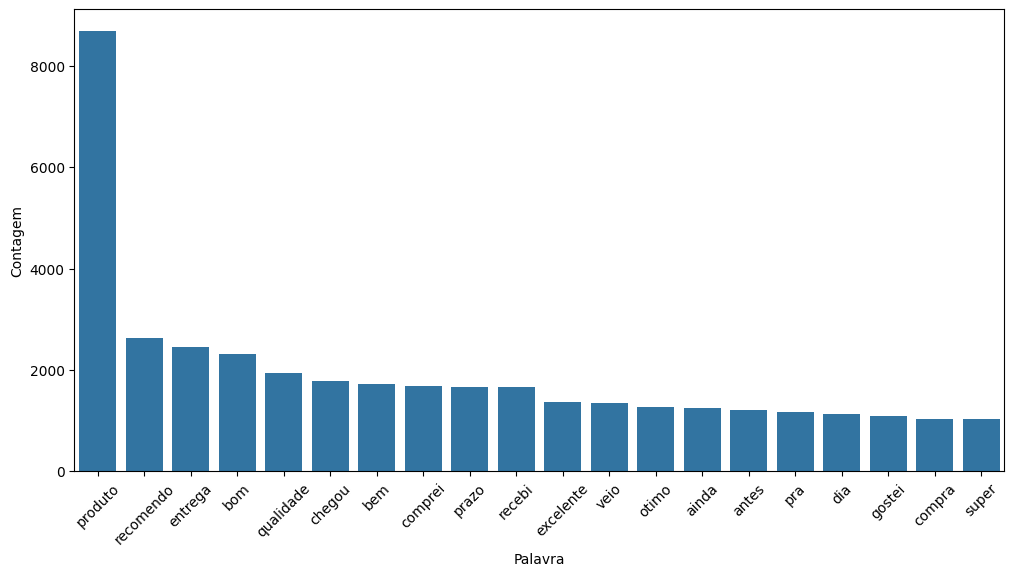

In [70]:
classificar_texto(df, 'frase_tratada_4', 'sentimento')
grafico_frequencia(df, 'frase_tratada_4', 20)

### Nuvem de palavras após o tratamento dos textos

Sentimento: positivo


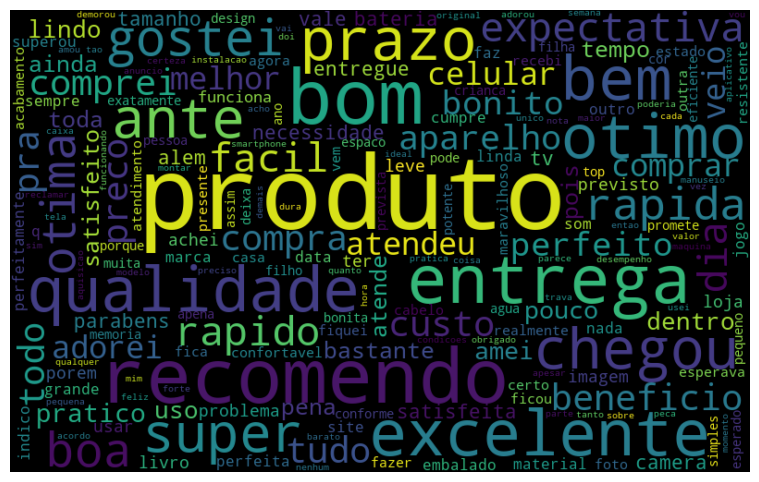

Sentimento: negativo


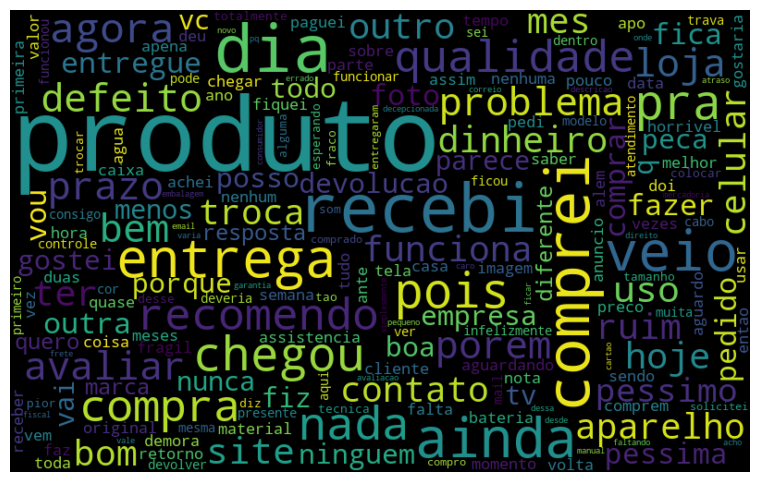

In [71]:
nuvem_palavras(df, 'frase_tratada_4', 'positivo')
nuvem_palavras(df, 'frase_tratada_4', 'negativo')

### Simplificando as palavras com **Stemming**

A técnica de Stemming consiste em simplificar as palavras de mesmo sentido, por exemplo:

- Eu **gostei** do produto
- Embora eu tenha **gostado** do produto, a entrega foi demorada

Por mais que as duas avaliações são positivas, as palavras gostei e gostado são interpretadas como palavras diferentes mesmo que tenham o mesmo significado.

O Stemming irá reduzir as palavras para o seu **radical** (geralmente removendo sufixos) com o objetivo de simplificar o processamento, no final a palavra gostei/gostado ficará: gost.

**OBS.** O **radical** de uma palavra é a parte que contém o seu significado principal e serve como base para a criação de novas palavras.

**Lematização**

Lematização é outra técnica relacionada que também simplifica as palavras, mas de outra maneira. Enquanto o stemming reduz a palavra sem considerar o contexto gramatical, a lematização transforma a palavra em sua forma "dicionarizada", ou seja, a palavra tal como aparece me um dicionário. Por exemplo, "correu" seria transformado em "correr", enquanto "correções" seria reduzido a "correção".

Essas técnicas são importantes para reduzir a variabilidade das palavras e aumentar a eficiência computacional e melhorar o desempenho do modelo, já que ele não será confundido por múltiplas formas de uma mesma ideia.

In [72]:
from nltk import RSLPStemmer

stemmer = RSLPStemmer()

# Exemplo com a palavra gostei
stemmer.stem('gostei')

'gost'

In [73]:
frases_processadas = []

for frase in df['frase_tratada_4']:
    frase = frase.lower()

    palavras_tokenizadas = token_pontuacao.tokenize(frase)
    
    # Antes de retornar a frase, realiza a simplificação de cada palavra
    frase_tratada = [stemmer.stem(palavra) for palavra in palavras_tokenizadas if palavra.isalpha() and palavra not in stopwords_sem_acentos]

    frases_processadas.append(' '.join(frase_tratada))

df['frase_tratada_5'] = frases_processadas

df.head()

,ID_avaliacao,avaliacao,nota,sentimento,frase_tratada,frase_tratada_2,frase_tratada_3,frase_tratada_4,frase_tratada_5
0,81841,"Esse smartphone superou minhas expectativas, r...",5,positivo,"Esse smartphone superou expectativas, recomendo",Esse smartphone superou expectativas recomendo,Esse smartphone superou expectativas recomendo,smartphone superou expectativas recomendo,smartphon super expect recom
1,28031,o cheiro e muito desagradavel!! pra quem se in...,2,negativo,cheiro desagradavel!! pra incomoda nao recomen...,cheiro desagradavel pra incomoda nao recomendoo,cheiro desagradavel pra incomoda recomendoo,cheiro desagradavel pra incomoda recomendoo,cheir desagrada pra incomod recomendo
2,91332,"Eu fiz a compra a loja não entregou o produto,...",1,negativo,"Eu fiz compra loja entregou produto, compra fe...",Eu fiz compra loja entregou produto compra fei...,Eu fiz compra loja entregou produto compra fei...,fiz compra loja entregou produto compra feita ...,fiz compr loj entreg produt compr feit carta c...
3,110045,"Atendeu minhas expectativas, só achei a luz ru...",4,positivo,"Atendeu expectativas, achei luz ruim, nada dif...",Atendeu expectativas achei luz ruim nada dific...,Atendeu expectativas achei luz ruim nada dific...,atendeu expectativas achei luz ruim nada dific...,atend expect ach luz ruim nad dificult funcion
4,36929,"Gostei muito, só achei que ficou a desejar a q...",5,positivo,"Gostei muito, achei ficou desejar qualidade fo...",Gostei achei ficou desejar qualidade fotos Ach...,Gostei achei ficou desejar qualidade fotos Ach...,gostei achei ficou desejar qualidade fotos ach...,gost ach fic desej qual fot ach bem melhor


In [74]:
# O tratamento com stemming aumentou 2% na acurácia do modelo
classificar_texto(df, 'frase_tratada_5', 'sentimento')

Acurácia do modelo com a coluna "frase_tratada_5": 85.32%
